In [1]:
import os
import sys
import copy
import json
import importlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import time
import torch
import torchaudio
import tensorflow as tf
import tqdm

import peripheral_model
import perceptual_model
import phaselocknet_model
import util

importlib.reload(peripheral_model)
importlib.reload(perceptual_model)
importlib.reload(phaselocknet_model)
importlib.reload(util)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"
device


2024-10-10 16:01:48.313841: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


device(type='cuda', index=0)

In [2]:
dir_model = "../phaselocknet/models/sound_localization/extra_cochlearn_delayed_integration/arch07"
input_shape = [2, 60000, 2]
config_random_slice = {}

# dir_model = "../phaselocknet/models/spkr_word_recognition/extra_cochlearn/arch0_0000"
# input_shape = [2, 40000]
# config_random_slice = {}

with open(os.path.join(dir_model, "config.json")) as f:
    config_model = json.load(f)
with open(os.path.join(dir_model, "arch.json")) as f:
    architecture = json.load(f)

architecture[1]["args"]["dims"] = [3, 1, 2]
architecture[3]["args"]["dims"] = [3, 1, 2]
print(architecture[1])
print(architecture[3])

model = perceptual_model.PerceptualModel(
    architecture=architecture,
    input_shape=input_shape,
    heads={"label": 1},
)
# model(torch.zeros(input_shape))

tmp_shape = list(input_shape)
for name, layer in list(model.body.named_modules())[1:]:
    tmp_shape = layer(torch.zeros(tmp_shape)).shape
    print(name, tmp_shape)


{'args': {'dims': [3, 1, 2], 'name': 'coch_permute_before_conv'}, 'layer_type': 'permute'}
{'args': {'dims': [3, 1, 2], 'name': 'coch_permute_after_conv'}, 'layer_type': 'permute'}
coch_expand_last_dimension torch.Size([2, 60000, 2, 1])
coch_permute_before_conv torch.Size([2, 1, 60000, 2])
coch_conv torch.Size([2, 50, 60000, 2])
coch_permute_after_conv torch.Size([2, 2, 50, 60000])
coch_relu_after_filterbank torch.Size([2, 2, 50, 60000])
coch_resample torch.Size([2, 2, 50, 12000])
coch_relu_after_resample torch.Size([2, 2, 50, 12000])
conv_0 torch.Size([2, 32, 50, 11985])
pool_0 torch.Size([2, 32, 50, 11985])
relu_0 torch.Size([2, 32, 50, 11985])
batch_norm_0 torch.Size([2, 32, 50, 11985])
conv_1 torch.Size([2, 32, 50, 11978])
pool_1 torch.Size([2, 32, 50, 5989])
relu_1 torch.Size([2, 32, 50, 5989])
batch_norm_1 torch.Size([2, 32, 50, 5989])
conv_2 torch.Size([2, 64, 50, 5986])
pool_2 torch.Size([2, 64, 50, 5986])
relu_2 torch.Size([2, 64, 50, 5986])
batch_norm_2 torch.Size([2, 64, 50,

In [22]:
# dir_model = "../phaselocknet/models/sound_localization/extra_cochlearn_delayed_integration/arch01"
# input_shape = [2, 60000, 2]
# config_random_slice = {}

# dir_model = "../phaselocknet/models/sound_localization/extra_cochlearn/arch01"
# input_shape = [2, 60000, 2]
# config_random_slice = {}

dir_model = "../phaselocknet/models/spkr_word_recognition/extra_cochlearn/arch0_0000"
input_shape = [2, 40000]
config_random_slice = {}

# dir_model = "../phaselocknet/models/sound_localization/simplified_IHC3000_delayed_integration/arch01"
# input_shape = [2, 60000, 2]
# config_random_slice = {"size": [50, 10000], "buffer": [0, 1000]}

# dir_model = "../phaselocknet/models/sound_localization/simplified_IHC3000_delayed_integration/arch01"
# input_shape = [2, 60000, 2]
# config_random_slice = {"size": [50, 10000], "buffer": [0, 1000]}

# dir_model = "../phaselocknet/models/sound_localization/IHC3000_delayed_integration/arch01"
# input_shape = [2, 3, 50, 12000, 2]
# config_random_slice = {"size": [50, 10000], "buffer": [0, 500]}

# dir_model = "../phaselocknet/models/spkr_word_recognition/simplified_IHC3000/arch0_0000"
# input_shape = [2, 40000]
# config_random_slice = {"size": [50, 20000], "buffer": [0, 0]}

# dir_model = "../phaselocknet/models/spkr_word_recognition/IHC3000/arch0_0000"
# input_shape = [2, 3, 50, 20000]
# config_random_slice = {}

# dir_model = "../phaselocknet/models/sound_localization/simplified_IHC3000_delayed_integration/arch01"
# input_shape = [2, 50000, 2]
# config_random_slice = {"size": [50, 10000], "buffer": [0, 0]}

with open(os.path.join(dir_model, "config.json")) as f:
    config_model = json.load(f)
with open(os.path.join(dir_model, "arch.json")) as f:
    architecture = json.load(f)

if "cochlearn" in dir_model:
    architecture[1]["args"]["dims"] = [3, 1, 2]
    architecture[3]["args"]["dims"] = [3, 1, 2]

# config_model["kwargs_cochlea"]["kwargs_spike_generator_binomial"] = {}

model = phaselocknet_model.Model(
    config_model=copy.deepcopy(config_model),
    architecture=copy.deepcopy(architecture),
    input_shape=input_shape,
    config_random_slice=copy.deepcopy(config_random_slice),
).to(device)

for k, v in model(torch.zeros(model.input_shape, device=device)).items():
    print(k, v.shape, v.dtype)

util.load_tf_model_checkpoint(
    model=model.perceptual_model,
    filename=os.path.join(dir_model, "ckpt_BEST"),
)
model.train(mode=False)


[WARNING] layer_type='reshape' --> torch.nn.Identity
label_speaker_int torch.Size([2, 433]) torch.float32
label_word_int torch.Size([2, 794]) torch.float32
[load_tf_model_checkpoint] missing_keys (../phaselocknet/models/spkr_word_recognition/extra_cochlearn/arch0_0000/ckpt_BEST)
|__ body.coch_resample.fir
|__ body.block0_pool.weight
|__ body.block1_pool.weight
|__ body.block2_pool.weight
|__ body.block3_pool.weight
|__ body.block4_pool.weight
|__ body.block5_pool.weight
|__ body.block6_pool.weight
[load_tf_model_checkpoint] ../phaselocknet/models/spkr_word_recognition/extra_cochlearn/arch0_0000/ckpt_BEST


Model(
  (peripheral_model): PeripheralModel(
    (body): Sequential(
      (cochlear_filterbank): Identity()
    )
    (head): Identity()
  )
  (perceptual_model): PerceptualModel(
    (body): Sequential(
      (coch_expand_last_dimension): ExpandLastDimension()
      (coch_permute_before_conv): Permute()
      (coch_conv): CustomPaddedConv2d(1, 50, kernel_size=(1, 1001), stride=(1, 1))
      (coch_permute_after_conv): Permute()
      (coch_relu_after_filterbank): ReLU()
      (coch_resample): FIRResample()
      (coch_relu_after_resample): ReLU()
      (input_reshape): Identity()
      (input_norm): CustomNorm()
      (block0_conv): CustomPaddedConv2d(1, 32, kernel_size=(2, 42), stride=(1, 1))
      (block0_relu): ReLU()
      (block0_pool): HanningPooling()
      (block0_norm): CustomNorm()
      (block1_conv): CustomPaddedConv2d(32, 64, kernel_size=(2, 18), stride=(1, 1))
      (block1_relu): ReLU()
      (block1_pool): HanningPooling()
      (block1_norm): CustomNorm()
      (bloc

In [23]:
sys.path.append("../phaselocknet")
import util_cochlea
import util_network
import util_signal


with open(os.path.join(dir_model, "config.json")) as f:
    config_model = json.load(f)
with open(os.path.join(dir_model, "arch.json")) as f:
    architecture = json.load(f)


def model_io_function(x):
    y = x
    if config_model.get("kwargs_cochlea", {}):
        if "label_loc_int" in config_model["n_classes_dict"]:
            msg = "expected [batch, freq, time, spont, channel=2] or [batch, time, channel=2]"
            assert (len(y.shape) in [3, 5]) and (y.shape[-1] == 2), msg
            y0, _ = util_cochlea.cochlea(y[..., 0], **copy.deepcopy(config_model["kwargs_cochlea"]))
            y1, _ = util_cochlea.cochlea(y[..., 1], **copy.deepcopy(config_model["kwargs_cochlea"]))
            y = tf.concat([y0, y1], axis=-1)
            if y.shape[2] > 10000:
                print(y.shape, y.shape, y.shape)
                y = util_cochlea.random_slice(
                    y,
                    slice_length=10000,
                    axis=2, # Time axis
                    buffer=1000)
        else:
            y, _ = util_cochlea.cochlea(y, **copy.deepcopy(config_model["kwargs_cochlea"]))
    y, _ = util_network.build_network(y, architecture, n_classes_dict=config_model["n_classes_dict"])
    return y


inputs = tf.keras.Input(shape=input_shape[1:], batch_size=None, dtype=tf.float32)
tf_model = tf.keras.Model(inputs=inputs, outputs=model_io_function(inputs))
tf_model.load_weights(os.path.join(dir_model, "ckpt_BEST"))
# tf_model.summary()


[tf_fir_resample] interpreted `tensor_input.shape` as [batch, freq=50, time=40000, channels=1]
[tf_fir_resample] `kwargs_fir_lowpass_filter`: {'fir_dur': 0.01, 'window': ['kaiser', 5.0], 'cutoff': 5000.0}
[fir_lowpass_filter] sr_filt = 20000.0 Hz
[fir_lowpass_filter] numtaps = 201 samples
[fir_lowpass_filter] fir_dur = 0.01 seconds
[fir_lowpass_filter] cutoff = 5000.0 Hz
[fir_lowpass_filter] window = ('kaiser', 5.0)


In [110]:
# x = np.random.randn(*input_shape).astype(np.float32)

# nervegram_torch = model.peripheral_model(torch.tensor(x).to(device)).cpu().numpy()
# print(nervegram_torch.shape, nervegram_torch.dtype)

# nervegram_tf = tf_model(x).numpy()
# nervegram_tf = np.transpose(nervegram_tf, [0, 3, 1, 2])
# print(nervegram_tf.shape, nervegram_tf.dtype)

# np.isclose(nervegram_torch, nervegram_tf).mean()


In [111]:
# fig, ax = plt.subplots(figsize=(16, 8))

# IDX = (0, 0, -4)
# # ax.plot(nervegram_tf[IDX], ls="-", color="k")
# # ax.plot(nervegram_torch[IDX], ls="--", color="r", lw=0.5)
# ax.plot(nervegram_torch[IDX].reshape([-1]) - nervegram_tf[IDX].reshape([-1]), ls="-", color="g", lw=0.5)
# plt.show()

# print(scipy.stats.pearsonr(nervegram_torch[IDX].reshape([-1]), nervegram_tf[IDX].reshape([-1])))


In [112]:
# torch_coch = model.peripheral_model.body.cochlear_filterbank.fb(torch.tensor(x[..., 0]).to(device)).cpu().numpy()

# tf_coch = util_signal.fir_gammatone_filterbank(
#     x[..., 0],
#     sr=config_model["kwargs_cochlea"]["sr_input"],
#     fir_dur=config_model["kwargs_cochlea"]["config_filterbank"]["fir_dur"],
#     min_cf=config_model["kwargs_cochlea"]["config_filterbank"]["min_cf"],
#     max_cf=config_model["kwargs_cochlea"]["config_filterbank"]["max_cf"],
#     num_cf=config_model["kwargs_cochlea"]["config_filterbank"]["num_cf"],
#     return_io_function=False
# ).numpy()

# torch_coch.shape, tf_coch.shape, np.isclose(torch_coch, tf_coch).mean()


In [24]:
x = np.random.randn(*input_shape).astype(np.float32)

model.eval()
out_torch = model(torch.tensor(x).to(device))
out_torch = out_torch["label_word_int"].cpu().detach().numpy()
print(out_torch.shape, out_torch.dtype)

out_tf = tf_model(x, training=False)["label_word_int"].numpy()
print(out_tf.shape, out_tf.dtype)

out_torch.min(), out_torch.max(), out_tf.min(), out_tf.max()


(2, 794) float32
(2, 794) float32


(-2.8945358, 10.829865, -3.0801497, 10.661727)

In [17]:
x = np.random.randn(*input_shape).astype(np.float32)

model.eval()
out_torch = model(torch.tensor(x).to(device))
out_torch = out_torch["label_loc_int"].cpu().detach().numpy()
print(out_torch.shape, out_torch.dtype)

out_tf = tf_model(x, training=False)["label_loc_int"].numpy()
print(out_tf.shape, out_tf.dtype)

out_torch.min(), out_torch.max(), out_tf.min(), out_tf.max()


(2, 504) float32
(2, 504) float32


(-71.656624, -45.523827, 2.6241925, 4.8966274)

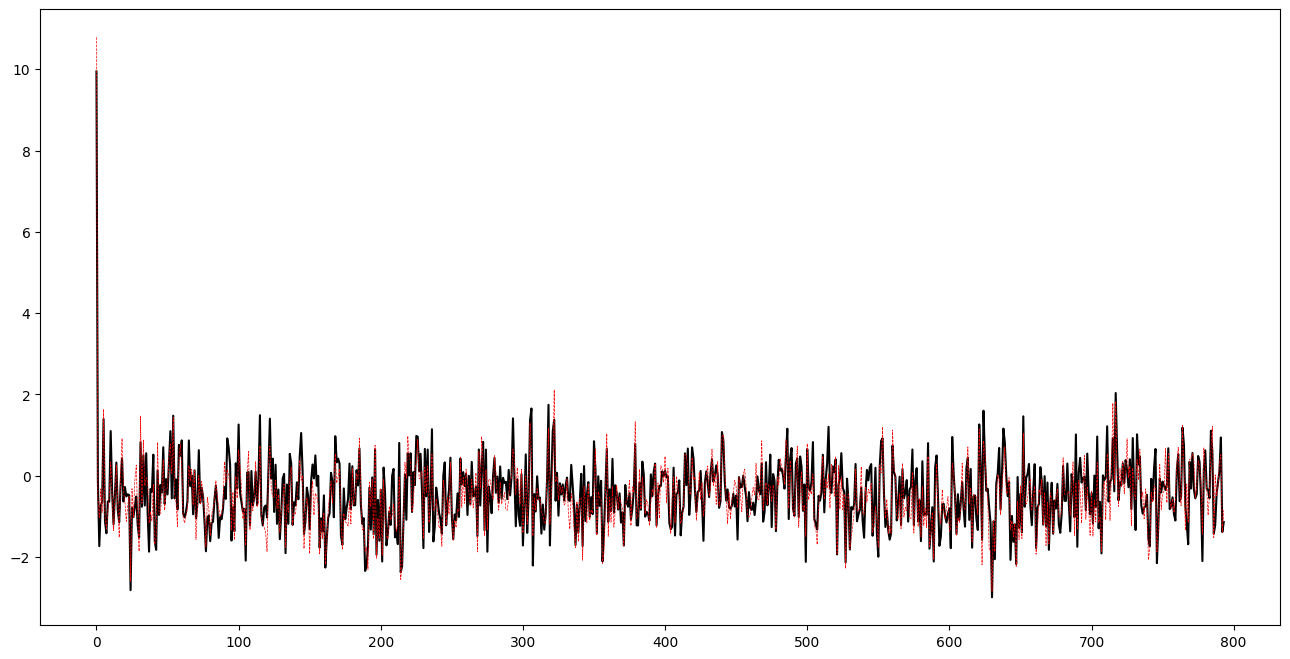

PearsonRResult(statistic=0.8783115738214321, pvalue=4.7788762082736857e-256)


In [25]:
fig, ax = plt.subplots(figsize=(16, 8))
IDX = 0
ax.plot(out_tf[IDX], ls="-", color="k")
ax.plot(out_torch[IDX], ls="--", color="r", lw=0.5)
plt.show()

print(scipy.stats.pearsonr(out_torch[IDX].reshape([-1]), out_tf[IDX].reshape([-1])))


In [14]:
for _ in tqdm.tqdm(range(20)):
    x = torch.randn(model.input_shape, device=device)
    model(x)
x.shape


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 57.46it/s]


torch.Size([2, 60000, 2])

In [26]:
# regex_filenames = "../phaselocknet/stimuli/sound_localization/evaluation/speech_in_noise_in_reverb_v04/stim.hdf5"
# regex_filenames = "../phaselocknet/stimuli/sound_localization/evaluation/mp_spectral_cues/stim.hdf5"
regex_filenames = "../phaselocknet/stimuli/spkr_word_recognition/evaluation/pitch_altered_v00/stim.hdf5"
batch_size = 32
sr = 50000 if "sound_localization" in regex_filenames else 20000
num_steps_per_display = 10
dataset = util.HDF5Dataset(regex_filenames)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    num_workers=1,
    shuffle=False,
)


In [27]:
fn_eval_output = "tmp.csv"
overwrite = True
write_prob = True

if os.path.exists(fn_eval_output):
    if overwrite:
        print(f"[evaluate] Overwriting pre-existing {fn_eval_output=}")
        os.remove(fn_eval_output)
    else:
        print(f"[complete] {fn_eval_output=} already exists!")
        raise ValueError(f"[complete] {fn_eval_output=} already exists!")
if os.path.exists(fn_eval_output + "~"):
    print(f"[evaluate] Deleting pre-existing tempfile: {fn_eval_output}~")
    os.remove(fn_eval_output + "~")

if write_prob:
    df_prob = []
    fn_eval_prob = fn_eval_output.replace(".csv", "_prob.gz")
    if os.path.exists(fn_eval_prob):
        print(f"[evaluate] Deleted pre-existing {fn_eval_prob=}")
        os.remove(fn_eval_prob)

model.eval()
with torch.no_grad():
    t0 = time.time()
    for step, example in enumerate(dataloader):
        x = example.pop("signal").type(torch.float32)
        sr_src = example["sr"][0].item()
        if step == 0:
            resampler = torchaudio.transforms.Resample(
                orig_freq=sr_src,
                new_freq=sr,
            )
            print(f"[evaluate] resampling audio from {sr_src} to {sr} Hz")
        if x.ndim > 2:
            x = torch.stack(
                [resampler(x[..., channel]) for channel in range(x.shape[-1])],
                axis=-1,
            )
        else:
            x = resampler(x)
            if len(model.input_shape) > 2:
                x = torch.stack([x for _ in range(model.input_shape[-1])], axis=-1)
        x = util.pad_or_trim_to_len(x, n=model.input_shape[1], dim=1)
        assert list(x.shape[1:]) == list(model.input_shape[1:])
        task_logits = model(x.to(device))
        task_preds = {
            k + ".pred": torch.argmax(v, dim=1) for k, v in task_logits.items()
        }
        example.update(task_preds)
        if write_prob:
            task_prob = {
                k + ".prob": torch.nn.functional.softmax(v, dim=1)
                for k, v in task_logits.items()
            }
            df_prob.append(
                pd.DataFrame(
                    {
                        k: list(v.detach().cpu().numpy())
                        for k, v in sorted(task_prob.items())
                    }
                )
            )
        example = {
            k: list(v.detach().cpu().numpy()) for k, v in sorted(example.items())
        }
        df = pd.DataFrame(example)
        df.to_csv(
            fn_eval_output + "~",
            mode="a",
            header=not os.path.exists(fn_eval_output + "~"),
            index=False,
        )
        if step % num_steps_per_display == num_steps_per_display - 1:
            display_str = util.get_model_progress_display_str(
                epoch=0,
                step=step + 1,
                num_steps=step + 1,
                t0=t0,
                mem=True,
            )
            print(display_str)
if write_prob:
    df_prob = pd.concat(df_prob).reset_index(drop=True)
    df_prob.to_pickle(fn_eval_prob + "~", compression="gzip")
    os.rename(fn_eval_prob + "~", fn_eval_prob)
    print(f"[complete] {fn_eval_prob=}")
os.rename(fn_eval_output + "~", fn_eval_output)
print(f"[complete] {fn_eval_output=}")


[evaluate] Overwriting pre-existing fn_eval_output='tmp.csv'
[evaluate] Deleted pre-existing fn_eval_prob='tmp_prob.gz'
[evaluate] resampling audio from 20000 to 20000 Hz
step 00_000010 | 0.2853 s/step | mem: 18.293 GB | 
step 00_000020 | 0.2764 s/step | mem: 18.293 GB | 
step 00_000030 | 0.2735 s/step | mem: 18.293 GB | 
step 00_000040 | 0.2722 s/step | mem: 18.293 GB | 
step 00_000050 | 0.2714 s/step | mem: 18.293 GB | 
step 00_000060 | 0.2708 s/step | mem: 18.293 GB | 
step 00_000070 | 0.2704 s/step | mem: 18.293 GB | 
step 00_000080 | 0.2702 s/step | mem: 18.293 GB | 
step 00_000090 | 0.2701 s/step | mem: 18.293 GB | 
step 00_000100 | 0.2699 s/step | mem: 18.293 GB | 
step 00_000110 | 0.2698 s/step | mem: 18.293 GB | 
step 00_000120 | 0.2697 s/step | mem: 18.293 GB | 
step 00_000130 | 0.2697 s/step | mem: 18.293 GB | 
step 00_000140 | 0.2697 s/step | mem: 18.293 GB | 
step 00_000150 | 0.2697 s/step | mem: 18.293 GB | 
step 00_000160 | 0.2697 s/step | mem: 18.293 GB | 
step 00_00017

dbspl False
foreground_azimuth True
foreground_elevation True
idx True
index True
! label_loc_int:labels_pred
! label_loc_int:labels_true
! label_loc_int:probs_out
loc_idx True
noise_high True
noise_low True
! signal_fs
sr True


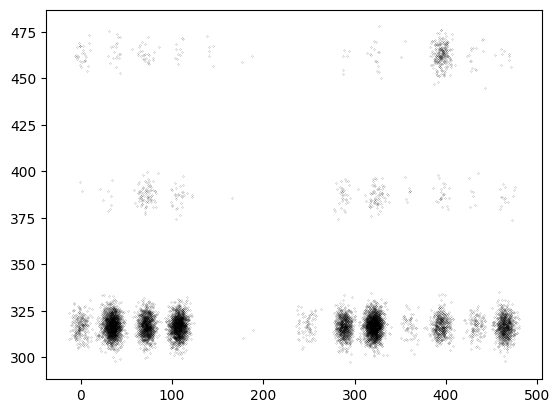

(PearsonRResult(statistic=0.1410955788350215, pvalue=9.354998195494883e-45),
 SignificanceResult(statistic=0.1402346122265442, pvalue=3.158047133755036e-44))

In [21]:
df0 = pd.read_csv(fn_eval_output)
fn = os.path.join(dir_model, "EVAL_PSYCHOPHYSICSv00_mp_spectral_cues.json")
df1 = pd.read_json(fn).sort_values(by="index").reset_index(drop=True)

for c in df1.columns:
    if c in df0.columns:
        print(c, np.array_equal(df0[c].values, df1[c].values))
    else:
        print("!", c)

fig, ax = plt.subplots()
x = df1["label_loc_int:labels_pred"].values
y = df0["label_loc_int.pred"].values
ax.plot(x + 5 * np.random.randn(*y.shape), y + 5 * np.random.randn(*y.shape), "k.", ms=0.2)
plt.show()

scipy.stats.pearsonr(x, y), scipy.stats.spearmanr(x, y)


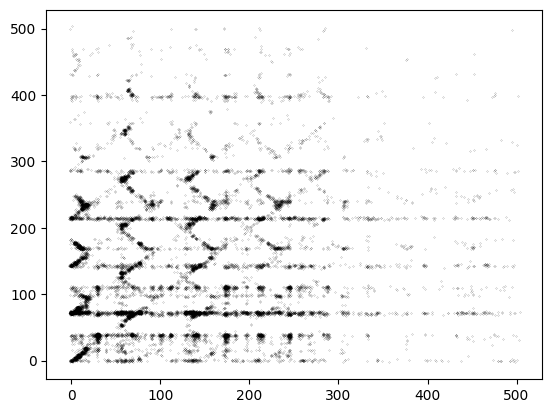

(PearsonRResult(statistic=0.09967354422384994, pvalue=1.0185401591659618e-42),
 SignificanceResult(statistic=0.09849514320543601, pvalue=9.457196290683313e-42))

In [32]:
df0 = pd.read_csv(fn_eval_output)
fn = os.path.join(dir_model, "EVAL_PSYCHOPHYSICSv00_speech_in_noise_in_reverb_v04.json")
df1 = pd.read_json(fn).sort_values(by="index").reset_index(drop=True)

df0 = df0.sort_values(
    by=[
        "index",
        "snr",
        "index_room",
        "index_brir",
        "label_speaker_int",
        "label_word_int",
    ]
)
df1 = df1.sort_values(
    by=[
        "index",
        "snr",
        "index_room",
        "index_brir",
        "label_speaker_int",
        "label_word_int",
    ]
)

fig, ax = plt.subplots()
x = df1["label_loc_int:labels_pred"].values
y = df0["label_loc_int.pred"].values
ax.plot(x + 1 * np.random.randn(*y.shape), y + 1 * np.random.randn(*y.shape), "k.", ms=0.2)
plt.show()

scipy.stats.pearsonr(x, y), scipy.stats.spearmanr(x, y)


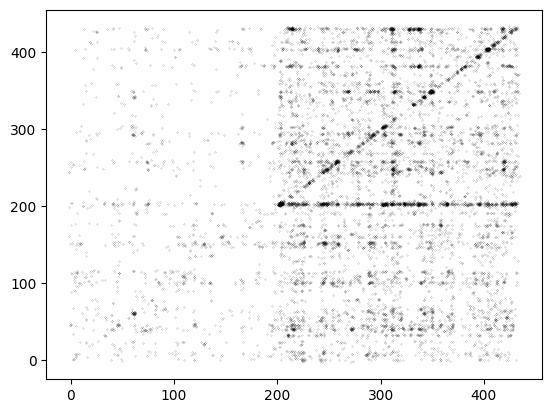

(PearsonRResult(statistic=0.17137772397847023, pvalue=1.158466911495275e-69),
 SignificanceResult(statistic=0.15368986599019352, pvalue=3.18420284512716e-56))

In [28]:
df0 = pd.read_csv(fn_eval_output)
fn = os.path.join(dir_model, "EVAL_pitch_altered_v00.json")
df1 = pd.read_json(fn).sort_values(by="index").reset_index(drop=True)

fig, ax = plt.subplots()
x = df1["label_speaker_int:labels_pred"].values
y = df0["label_speaker_int.pred"].values
ax.plot(x + 1 * np.random.randn(*y.shape), y + 1 * np.random.randn(*y.shape), "k.", ms=0.2)
plt.show()

scipy.stats.pearsonr(x, y), scipy.stats.spearmanr(x, y)
